In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

In [6]:
lead = 1
filepath_config = os.path.join(r'../result/config', 'variable_stack_' + str(lead) + '.pkl')
with open(filepath_config, 'rb') as f:
    config = pickle.load(f)
filepath_checkpoint = r'../result/checkpoint/variable_stack_'+ str(lead) + '.pth'

In [7]:
config.keys()

dict_keys(['model', 'dataset', 'train', 'log'])

In [8]:
config['dataset'].keys()

dict_keys(['lead', 'time_axis', 'dir_dataset', 'filepath_statistics', 'lst_variable_feature', 'lst_is_mask_feature', 'lst_level_feature', 'lst_variable_label', 'lst_is_mask_label', 'lst_level_label', 'dim_level_cat', 'break_percent', 'batch_size', 'shuffle', 'drop_last', 'num_workers'])

In [9]:
# # load model
from package.SimVP_Simpler_yet_Better_Video_Prediction_master.model import SimVP
from collections import OrderedDict

device_ids = [0]
gpu_num = len(device_ids)

shape_in_ = config['model']['shape_in']
seq_len_, channel_in_, H_, W_ = shape_in_
channel_out_ = config['model']['channel_out']
hid_S_ = config['model']['hid_S']
hid_T_ = config['model']['hid_T']
N_S_ = config['model']['N_S']
N_T_ = config['model']['N_T']
groups_ = config['model']['groups']

model = SimVP(shape_in=shape_in_, channel_out=channel_out_,
               hid_S=hid_S_, hid_T=hid_T_, N_S=N_S_, N_T=N_T_,
               groups=groups_)
model = model.cuda(device=device_ids[0])

checkpoint = torch.load(filepath_checkpoint, weights_only=False, map_location='cuda:0')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [25]:
# # build dataset
from package.utils.MyDataset import Dataset
from torch.utils.data import Subset, DataLoader

def transform_x(x):
    x = np.ascontiguousarray(x[np.newaxis, :])
    return x

def transform_y(y):
    y = np.ascontiguousarray(y[np.newaxis, :])
    return y

time_axis = np.load('../data/info_axis/time.npy')
dir_dataset = r'E:\dataset\dataset'
filepath_statistics = r'../data/statistics/all/statistics.pkl'

lst_variable_feature = config['dataset']['lst_variable_feature']
lst_is_mask_feature = config['dataset']['lst_is_mask_feature']
lst_level_feature = config['dataset']['lst_level_feature']

lst_variable_label = config['dataset']['lst_variable_label']
lst_is_mask_label = config['dataset']['lst_is_mask_label']
lst_level_label = config['dataset']['lst_level_label']

dim_level_cat = config['dataset']['dim_level_cat']
dataset = Dataset(lead,
                  time_axis, dir_dataset, filepath_statistics,
                  lst_variable_feature, lst_is_mask_feature, lst_level_feature,
                  lst_variable_label, lst_is_mask_label, lst_level_label,
                  dim_level_cat,
                  transform_x, transform_y)

indices = list(range(len(dataset)))
break_point = int(len(dataset) * config['dataset']['break_percent'])
indices_test = indices[break_point:]
dataset_test = Subset(dataset, indices_test)
dataloader_test = DataLoader(dataset_test, batch_size=1,
                             shuffle=False, drop_last=False, num_workers=0)

In [26]:
len(dataset_test)

512

In [ ]:
model.eval()
with torch.no_grad():
    for i, (feature_test, label_test) in enumerate(dataloader_test):
        feature_test = feature_test.cuda(device=0)
        label_test = label_test.cuda(device=0)
        predict_test = model(feature_test)
        x = predict_test.to('cpu').detach().numpy().squeeze(1)
        y = label_test.to('cpu').detach().numpy().squeeze(1)
        print(x.shape, y.shape)
        if i == 0:
            x_merge = x
            y_merge = y
        else:
            x_merge = np.concatenate((x_merge, x), axis=0)
            y_merge = np.concatenate((y_merge, y), axis=0)
print(x_merge.shape, y_merge.shape)

(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224, 224) (1, 157, 224, 224)
(1, 157, 224

In [16]:
lon = np.load('../data/info_axis/lon_img.npy')
lat = np.load('../data/info_axis/lat_img.npy')
time_axis = np.load('../data/info_axis/time.npy')[lead:][break_point:]

In [17]:
# RMSE
rmse = np.sqrt(np.mean((x_merge - y_merge) ** 2, axis=0))

In [23]:
lon_p, lat_p = 111, 15
idx_lon, idx_lat = np.argwhere(lon == lon_p)[0][0], np.argwhere(lat == lat_p)[0][0]
idx_v = 1

rmse:  0.10164441


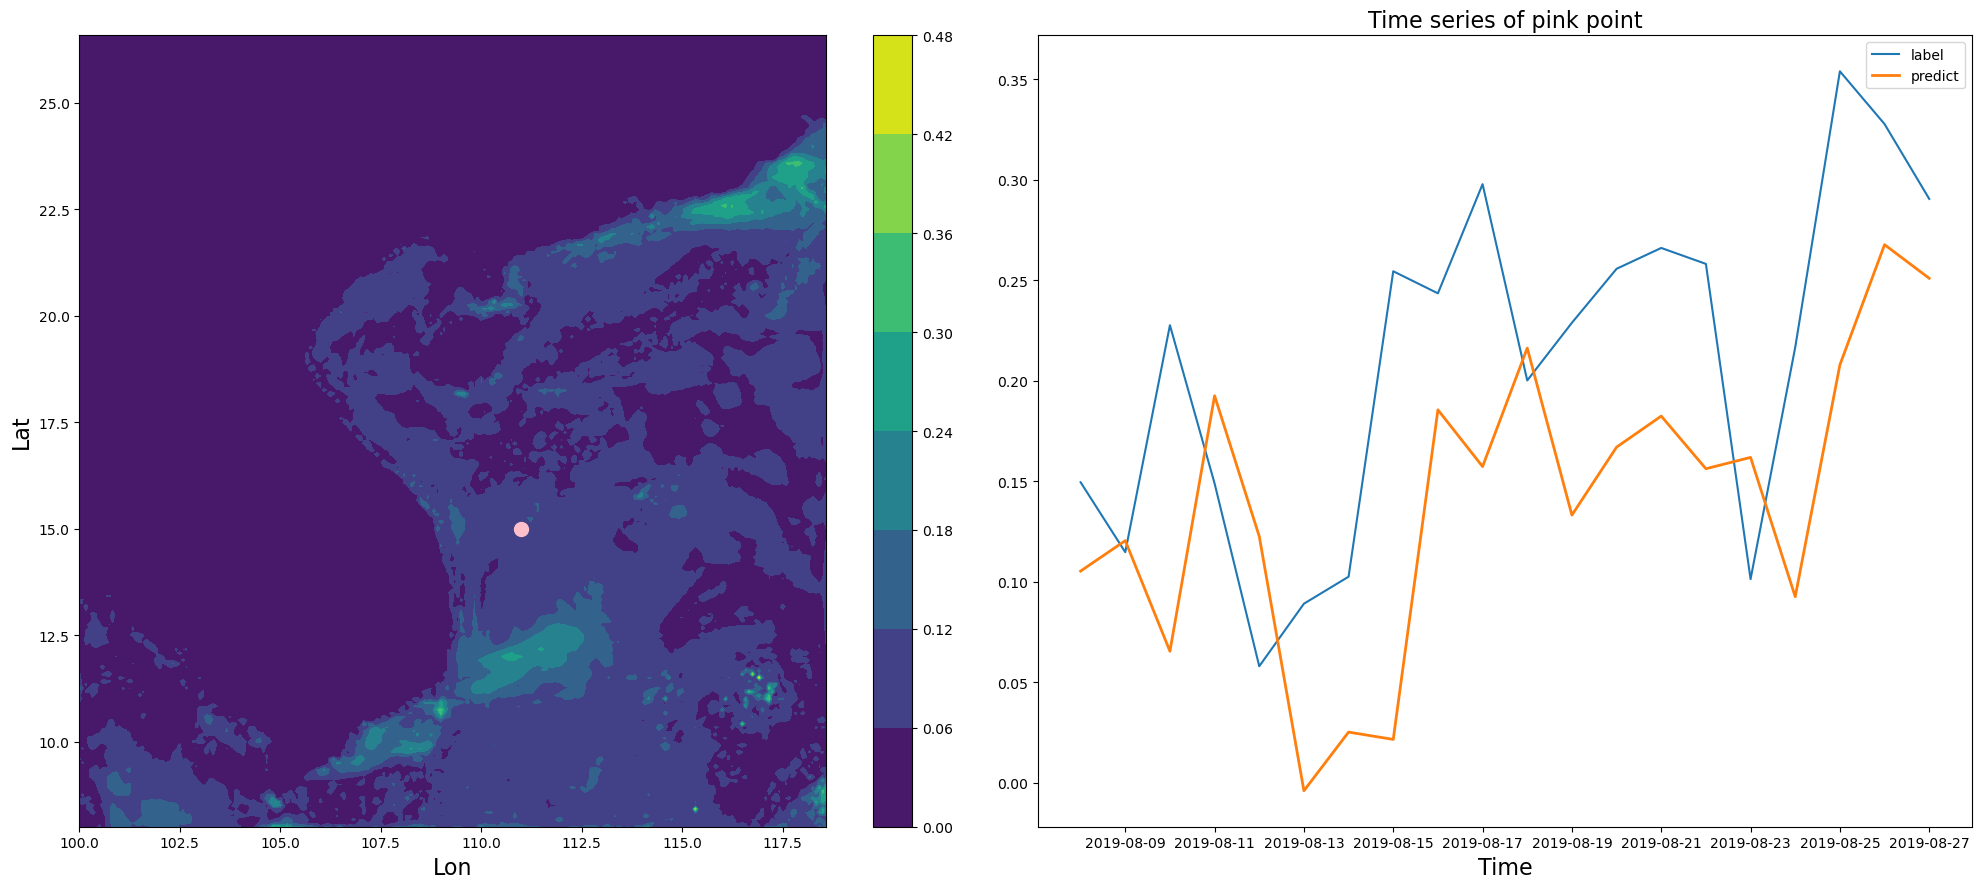

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(20, 9))

cf1 = axs[0].contourf(lon, lat, rmse[idx_v, :])
axs[0].scatter(lon[idx_lon], lat[idx_lat], s=100, color='pink')
axs[0].set_xlabel('Lon', fontsize=16)
axs[0].set_ylabel('Lat', fontsize=16)
fig.colorbar(cf1, ax=axs[0])

axs[1].plot(time_axis, y_merge[:, idx_v, idx_lat, idx_lon], label='label')
axs[1].plot(time_axis, x_merge[:, idx_v, idx_lat, idx_lon], label='predict',
            linewidth=2)
axs[1].set_xlabel('Time', fontsize=16)
axs[1].legend()
axs[1].set_title('Time series of pink point', fontsize=16)

plt.tight_layout()
plt.show()